# 1D Offshore Spectrum to Nearshore observations

This version of the code used pytorch

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#handy function for emptying the chached memory in a GPU
#the kernal should be restarted every time this is run
from numba import cuda
cuda.select_device(0)
cuda.close()

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [4]:
oneD_Off = pd.read_csv('../data/spec1D_offshore.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')

<Axes: >

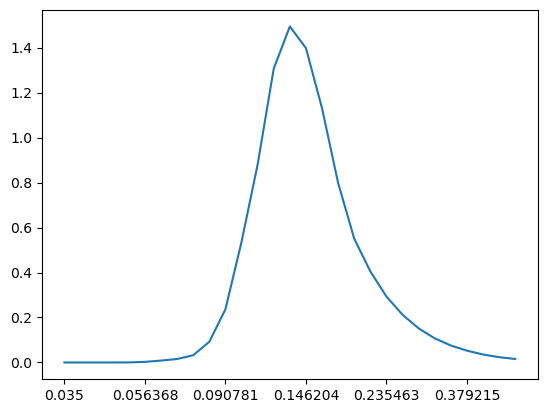

In [5]:
oneD_Off.iloc[0].plot()

We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [6]:
offStats = pd.read_csv("../data/stats_offshore.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats = offStats.drop(['lat', 'lon'], axis=1)

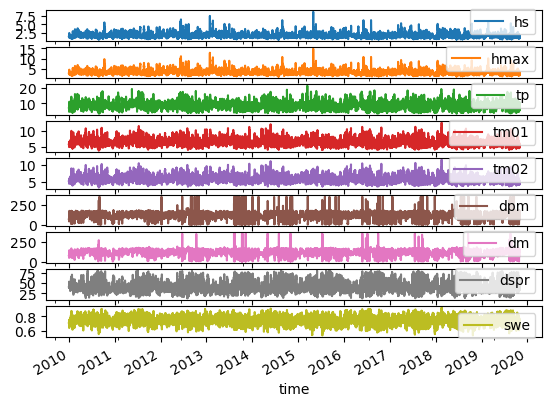

In [7]:
_ = offStats.plot(subplots = True)

## Read in SWAN Data

Read in SWAN spectrum.

In [8]:
SWAN = pd.read_csv('../data/spec1D_GC.csv', parse_dates = True, index_col = 0)

In [9]:
new_columns = [column + '_tgt' for column in SWAN.columns]
SWAN = SWAN.rename(columns=dict(zip(SWAN.columns, new_columns)))

In [10]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, SWAN, left_index=True, right_index=True)

<Axes: >

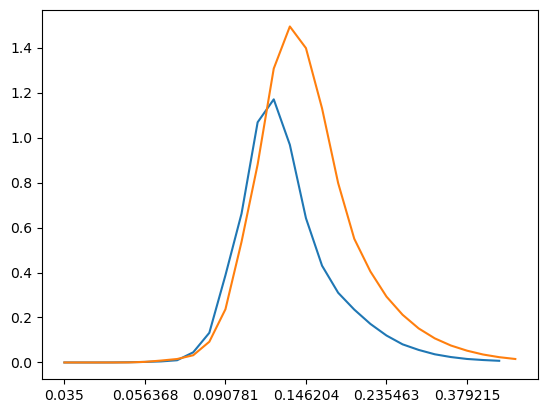

In [11]:
merged_df.filter(regex='tgt').iloc[0].plot()
oneD_Off.iloc[0].plot()

In [12]:
def calculate_Hm0(spectrum):
    # Calculate the square root of the sum of the squared amplitudes
    root_sum_squared = np.sqrt((spectrum ** 2).sum())

    # Find the index of the maximum value in the root_sum_squared
    idx_max = root_sum_squared.idxmax()

    # Hm0 is twice the amplitude at the frequency corresponding to the maximum value
    Hm0 = 2 * spectrum.loc[idx_max]

    return Hm0

In [13]:
def Hm0(energyArray, freq):
    
    freq = pd.to_numeric(freq, errors='coerce')
    fact = np.hstack((1.0, np.full(len(freq) - 2, 0.5), 1.0))
    ldif = np.hstack((0.0, np.diff(freq)))
    rdif = np.hstack((np.diff(freq), 0.0))
    E = energyArray * fact * (ldif + rdif)
    
    return (4 * np.sqrt(E.sum())).round(2)

In [14]:
freq = oneD_Off.iloc[0].index
Hm0(oneD_Off.iloc[0], freq)

1.53

In [15]:
merged_df.filter(regex='tgt').iloc[0]
Hm0(merged_df.filter(regex='tgt').iloc[0], SWAN.iloc[0].index.str.replace('_tgt', ""))

1.23

In [16]:
merged_df.iloc[0].hs.round(2)

1.54

## Feature Engineering

**Time Based**

In [17]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [18]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [19]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [20]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'swe', '0.038_tgt',
       '0.0418_tgt', '0.046_tgt', '0.0506_tgt', '0.0557_tgt', '0.0612_tgt',
       '0.0674_tgt', '0.0741_tgt', '0.0815_tgt', '0.0897_tgt', '0.0987_tgt',
       '0.1086_tgt', '0.1195_tgt', '0.1314_tgt', '0.1446_tgt', '0.1591_tgt',
       '0.175_tgt', '0.1925_tgt', '0.2118_tgt', '0.233_tgt', '0.2563_tgt',
       '0.282_tgt', '0.3103_tgt', '0.3413_tgt', '0.3755_tgt', '0.4131_tgt',
       '0.4545_tgt', '0.5_tgt', 'year', 'month', 'day', 'day_of_week', 'hour',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month

In [21]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('Dir_Tp TRUE_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [22]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

In [23]:
merged_df.dropna(inplace = True)

In [24]:
#merged_df = merged_df.iloc[::2, :] #make 3 hourly

## Keep some independent data

In [25]:
ind_data = merged_df["2019-01-01":]
merged_df  = merged_df[:"2019-01-01"]

## Selecting Training Data

In [26]:
merged_df.columns

Index(['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'hs', 'hmax',
       'tp', 'tm01', 'tm02', 'dspr', 'swe', '0.038_tgt', '0.0418_tgt',
       '0.046_tgt', '0.0506_tgt', '0.0557_tgt', '0.0612_tgt', '0.0674_tgt',
       '0.0741_tgt', '0.0815_tgt', '0.0897_tgt', '0.0987_tgt', '0.1086_tgt',
       '0.1195_tgt', '0.1314_tgt', '0.1446_tgt', '0.1591_tgt', '0.175_tgt',
       '0.1925_tgt', '0.2118_tgt', '0.233_tgt', '0.2563_tgt', '0.282_tgt',
       '0.3103_tgt', '0.3413_tgt', '0.3755_tgt', '0.4131_tgt', '0.4545_tgt',
       '0.5_tgt', 'year', 'month', 'day', 'day_of_week', 'hour', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month

In [27]:
features_col = ['0.035', '0.0385', '0.04235', '0.046585', '0.051244', '0.056368',
       '0.062005', '0.068205', '0.075026', '0.082528', '0.090781', '0.099859',
       '0.109845', '0.12083', '0.132912', '0.146204', '0.160824', '0.176907',
       '0.194597', '0.214057', '0.235463', '0.259009', '0.28491', '0.313401',
       '0.344741', '0.379215', '0.417136', '0.45885', '0.504735', 'dm_sin']

In [28]:
labels_col = merged_df.columns[merged_df.columns.str.contains('tgt')].to_list()

In [29]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [31]:
from sklearn.model_selection import TimeSeriesSplit

In [32]:
T = 12                    #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 12 × 30 × 52595


In [35]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [36]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, labels.shape[1]))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [37]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, labels.shape[1]))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [38]:
import torch
import torch.nn as nn

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [41]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [42]:
model = LSTM(D, 256, 2, labels.shape[1])
model.to(device)

LSTM(
  (rnn): LSTM(30, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)

In [43]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 30 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model_spec.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [44]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=500)

At epoch 30 of 500, Train Loss: 0.057, Test Loss: 0.057
current test best = 1.000, current test loss is: 0.057
At epoch 30 of 500, Train Loss: 0.057, Test Loss: 0.057
At epoch 60 of 500, Train Loss: 0.025, Test Loss: 0.039
current test best = 0.057, current test loss is: 0.039
At epoch 60 of 500, Train Loss: 0.025, Test Loss: 0.039
At epoch 90 of 500, Train Loss: 0.018, Test Loss: 0.038
current test best = 0.039, current test loss is: 0.038
At epoch 90 of 500, Train Loss: 0.018, Test Loss: 0.038
At epoch 120 of 500, Train Loss: 0.013, Test Loss: 0.042


Find the best model from the training and load that in over the top of the latest one!

In [45]:
resume(model, "best_model_spec.pth")

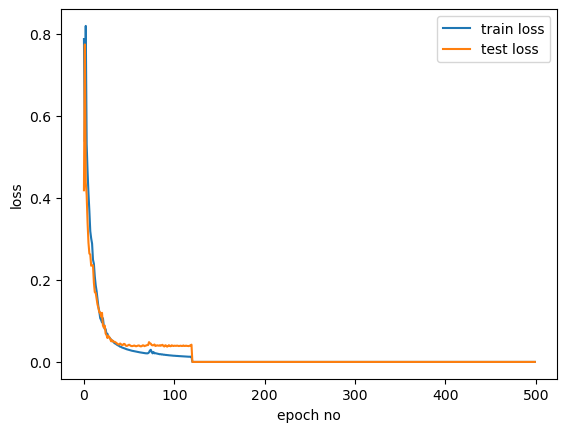

In [46]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

## Assess performance against test data

In [47]:

#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0].cpu().detach().numpy()
  
  # update the predictions list
  test_predictions.append(p)
  

In [48]:
p

array([ 0.00651994,  0.0041829 ,  0.01315755,  0.00707046, -0.00260071,
       -0.00764472,  0.01150867,  0.08737636,  0.27987838,  0.6851791 ,
        1.2611382 ,  1.5981209 ,  1.3997235 ,  0.9345585 ,  0.5641167 ,
        0.37988937,  0.28432146,  0.23310445,  0.17328969,  0.12782481,
        0.09183964,  0.06580476,  0.04619636,  0.0278784 ,  0.02428983,
        0.02109502,  0.00857297,  0.01021201], dtype=float32)

In [49]:
test_predictions = pd.DataFrame(test_predictions, columns = merged_df[labels_col].columns.str.replace('_tgt', "_pred"))

In [50]:
#calculate hs
test_predictions.apply(lambda row: Hm0(row, SWAN.iloc[0].index.str.replace('_tgt', "")), axis = 1).values

array([1.67, 1.64, 1.6 , ..., 1.27, 1.27, 1.28])

In [51]:

plot_len = len(test_predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['hs_tgt'] = merged_df.hs
plot_df['prediction'] = test_predictions.apply(lambda row: Hm0(row, SWAN.iloc[0].index.str.replace('_tgt', "")), axis = 1).values
plot_df.head(5)

,0.038_tgt,0.0418_tgt,0.046_tgt,0.0506_tgt,0.0557_tgt,0.0612_tgt,0.0674_tgt,0.0741_tgt,0.0815_tgt,0.0897_tgt,...,0.2563_tgt,0.282_tgt,0.3103_tgt,0.3413_tgt,0.3755_tgt,0.4131_tgt,0.4545_tgt,0.5_tgt,hs_tgt,prediction
2017-03-16 03:00:00,0.0,0.0,0.000183,0.000000,0.001008,0.005224,0.042158,0.044357,0.221054,0.786244,...,0.095588,0.061404,0.043166,0.028411,0.018055,0.011731,0.007423,0.005041,1.929722,1.67
2017-03-16 05:00:00,0.0,0.0,0.000178,0.000178,0.000801,0.004541,0.041852,0.038202,0.158149,0.596709,...,0.093856,0.059306,0.040962,0.026892,0.017275,0.011042,0.006857,0.004809,1.863803,1.64
2017-03-16 06:00:00,0.0,0.0,0.000248,0.000165,0.000660,0.003962,0.041596,0.035984,0.131144,0.525485,...,0.093097,0.058185,0.040111,0.026741,0.017414,0.010482,0.006850,0.004704,1.825655,1.60
2017-03-16 08:00:00,0.0,0.0,0.000199,0.000199,0.000596,0.003180,0.039820,0.033326,0.091167,0.424300,...,0.090505,0.057510,0.039356,0.026303,0.016696,0.010468,0.006626,0.004174,1.753954,1.56
2017-03-16 09:00:00,0.0,0.0,0.000191,0.000191,0.000573,0.002993,0.037700,0.033243,0.076420,0.381207,...,0.089347,0.057187,0.039038,0.025855,0.016812,0.010508,0.006623,0.004139,1.722724,1.52


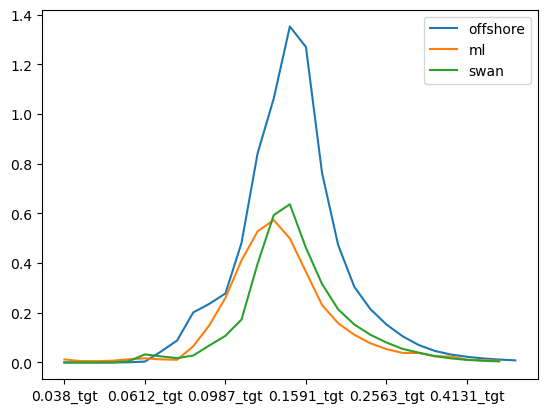

In [52]:
oneD_Off.iloc[120].plot(label = 'offshore')
test_predictions.iloc[120].plot(label = 'ml')
SWAN.iloc[120].plot(label ='swan')
plt.legend()

In [53]:
freq = oneD_Off.iloc[0].index
print("Offshore: "+str(Hm0(oneD_Off.iloc[100], freq)))

freq = SWAN.iloc[0].index.str.replace('_tgt', "")
print("ML: "+str(Hm0(test_predictions.iloc[100], freq)))

freq = SWAN.iloc[0].index.str.replace('_tgt', "")
print("SWAN: "+str(Hm0(SWAN.iloc[100], freq)))

Offshore: 1.7
ML: 1.19
SWAN: 1.28


Text(0, 0.5, 'Hs (m)')

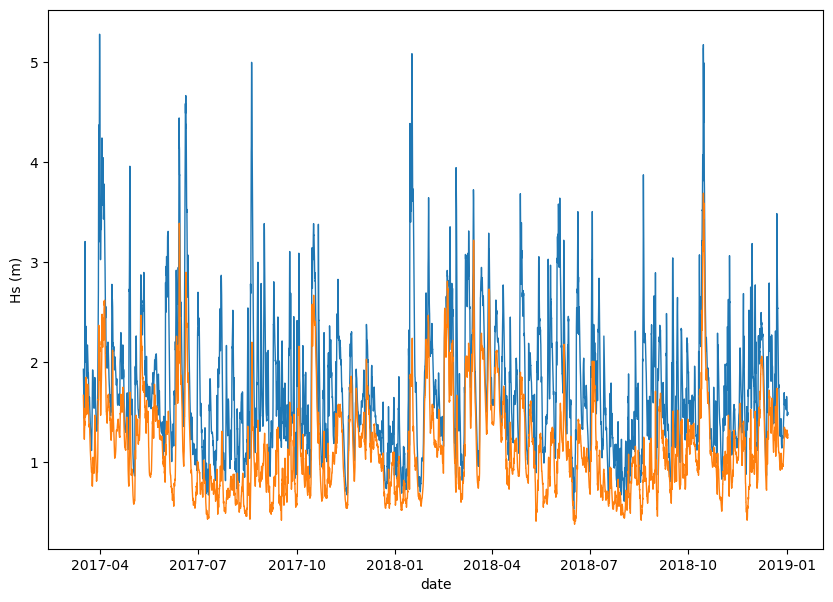

In [54]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df['hs_tgt'], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


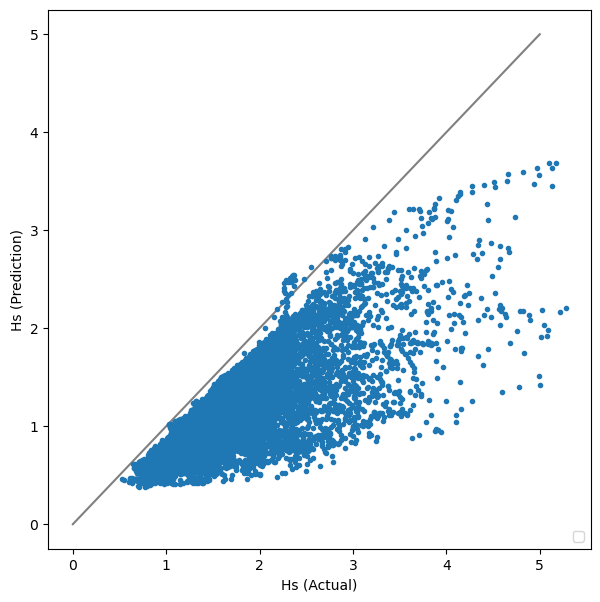

In [56]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df['hs_tgt'].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

In [57]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

ValueError: Shape of passed values is (10510, 28), indices imply (10510, 1)

In [ ]:
plt.hist(LTSM_error['error'], bins=50)
plt.xlabel('Hs Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

NameError: name 'LTSM_error' is not defined

## Test against independent data

In [ ]:
features_ind = scaler.transform(ind_data[features_col].values)

In [ ]:
len(ind_data)

1600

In [ ]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = int(len(ind_data) * 0.01)

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))
y_ind = np.zeros((N - ind_size, 1))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]
  y_ind[i] = (ind_data[labels_col].values[t+T])

In [ ]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))
y_ind = torch.from_numpy(y_ind.astype(np.float32))

X_ind, y_ind = X_ind.to(device), y_ind.to(device)

In [ ]:
X_ind[i].shape

torch.Size([12, 34])

In [ ]:
ind_predictions = []
for i in range(len(y_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  ind_predictions.append(p)

In [ ]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = ind_predictions
plot_df.head(5)

,hs_tgt,prediction
2019-01-06 09:00:00,1.42,1.264538
2019-01-06 14:00:00,1.41,1.275328
2019-01-06 18:00:00,1.38,1.298575
2019-01-06 23:00:00,1.44,1.290165
2019-01-07 03:00:00,1.40,1.295503


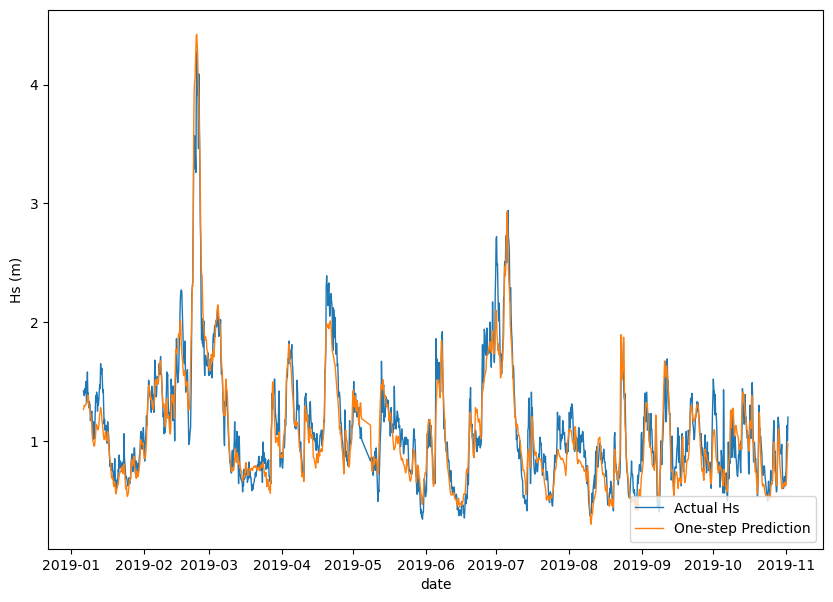

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


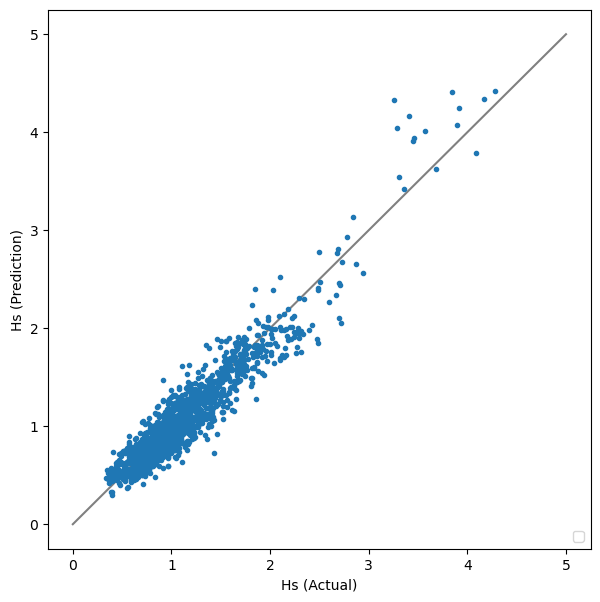

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

In [ ]:
import cal_stats

In [ ]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.04,
 'Root Mean Squared Error': 0.17,
 'Scatter Index': 15.0,
 'Coefficient of Determination': 0.9,
 'Coefficient of Efficiency': 0.89,
 'Correlation Coefficient': 0.95,
 'Index of Agreement': 0.97}

# Compare to a simple xboost model

In [ ]:
import xgboost as xgb

In [ ]:
features.shape

(17369, 34)

In [ ]:
labels.shape

(17369, 1)

In [ ]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

train_X, test_X = features[:train_size], features[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Fit the model
model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=False)

# Make predictions
predictions = model.predict(test_X)


In [ ]:
plot_len = len(predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-16 23:00:00,1.71,1.036096
2017-03-17 03:00:00,1.38,1.189543
2017-03-17 08:00:00,1.46,1.121853
2017-03-17 12:00:00,1.38,1.009145
2017-03-17 17:00:00,1.39,1.142602


Text(0, 0.5, 'Hs (m)')

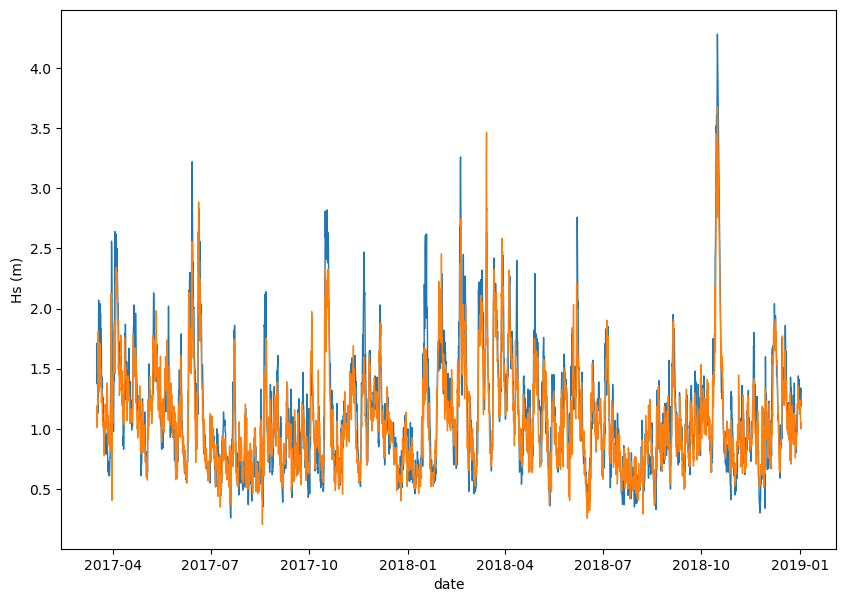

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(pd.DataFrame(predictions, index = plot_df.index), label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


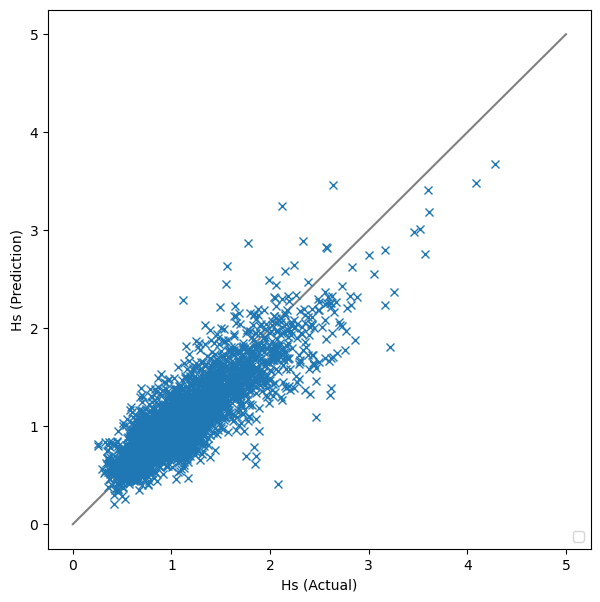

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], 'x')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

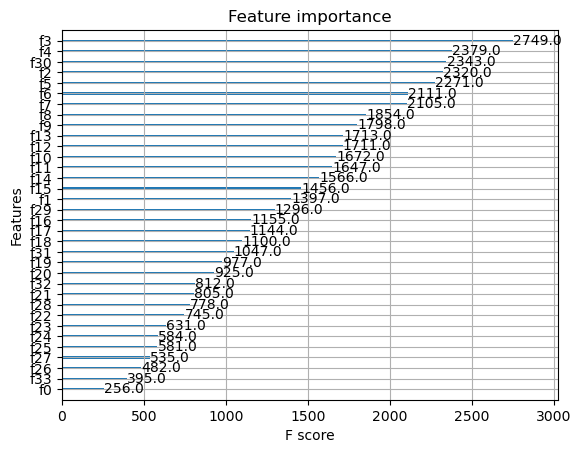

In [ ]:
plot_importance(model)
pyplot.show()

In [ ]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.05,
 'Root Mean Squared Error': 0.25,
 'Scatter Index': 22.1,
 'Coefficient of Determination': 0.74,
 'Coefficient of Efficiency': 0.73,
 'Correlation Coefficient': 0.86,
 'Index of Agreement': 0.92}